In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from pmdarima import auto_arima
import time
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")


# LSTM

## Implementation

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
df = pd.read_csv("../datasets/processed/agmarknet_punjab_tomato.csv", parse_dates=['date'])
df.set_index('date', inplace=True)

# Features and target
features = ['arrivals','min_price','max_price','price_range','year','month','day_of_week',
            'lagged_price_7','lagged_price_30','rolling_mean_7','rolling_mean_30',
            'exp_smooth','price_change','log_modal','z_score_7_rolling']
target = 'modal_price'

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

# Sequence generator
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=30)

# Train-test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Keras Tuner model builder
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='lstm_tune'
)

# Tuning
start = time.time()
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])
print(f"Tuning took {(time.time() - start)/60:.2f} minutes")

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train best model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=5)],
                         verbose=1)

# Predict
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Evaluation
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Trial 20 Complete [00h 00m 18s]
val_loss: 0.005952955223619938

Best val_loss So Far: 0.00536466995254159
Total elapsed time: 00h 04m 24s
Tuning took 4.40 minutes
Epoch 1/50
37/37 [==============================] - 2s 23ms/step - loss: 5.7464e-04 - val_loss: 0.0060
Epoch 2/50
37/37 [==============================] - 1s 15ms/step - loss: 6.0716e-04 - val_loss: 0.0055
Epoch 3/50
37/37 [==============================] - 1s 14ms/step - loss: 5.6756e-04 - val_loss: 0.0050
Epoch 4/50
37/37 [==============================] - 1s 15ms/step - loss: 5.2769e-04 - val_loss: 0.0054
Epoch 5/50
37/37 [==============================] - 1s 15ms/step - loss: 5.3296e-04 - val_loss: 0.0054
Epoch 6/50
37/37 [==============================] - 1s 14ms/step - loss: 5.3630e-04 - val_loss: 0.0054
Epoch 7/50
37/37 [==============================] - 1s 14ms/step - loss: 5.2620e-04 - val_loss: 0.0049
Epoch 8/50
37/37 [==============================] - 1s 14ms/step - loss: 5.2532e-04 - val_loss: 0.0057
Epoch 9/50
37

## Visualizations

12/12 [==============================] - 0s 5ms/step


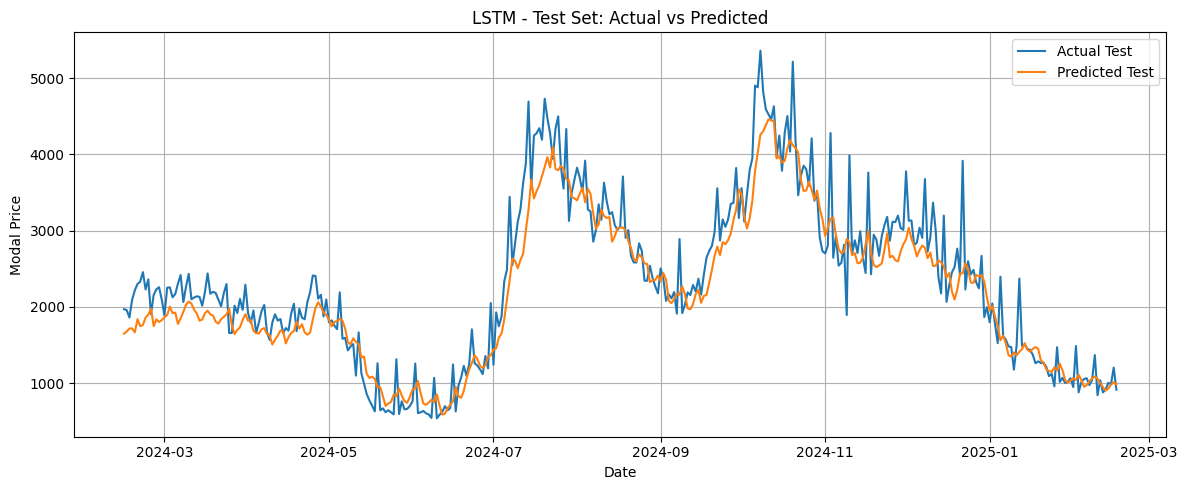

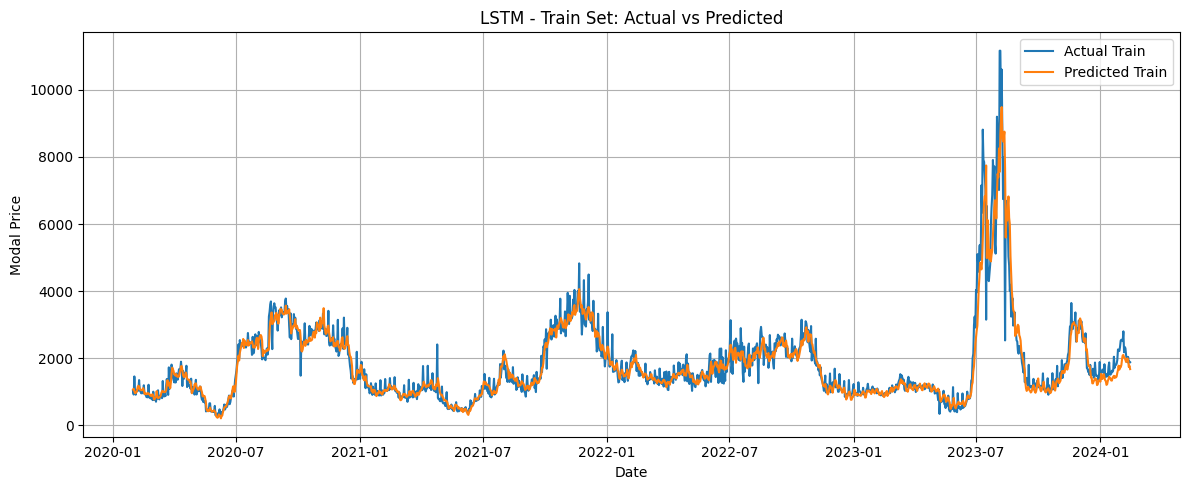

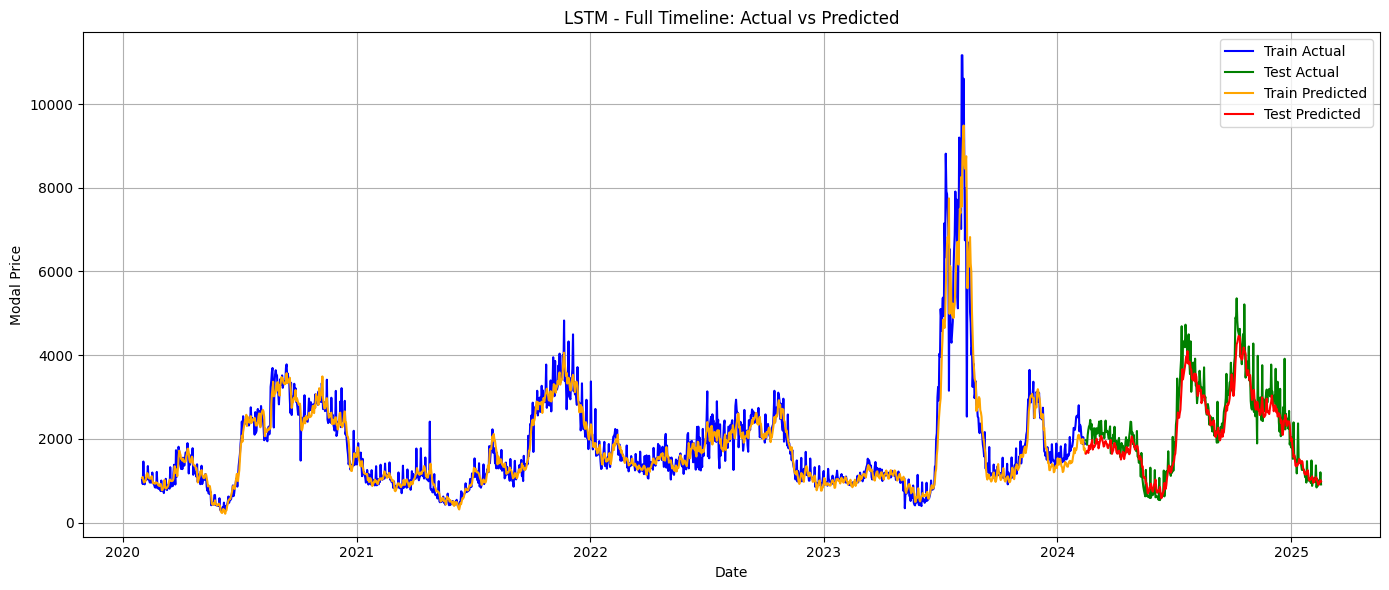

In [4]:
sequence_length = 30
split_index = int(0.8 * len(X_seq))

# Inverse transforms
y_train_actual = scaler_y.inverse_transform(y_train)
y_train_pred_actual = scaler_y.inverse_transform(best_model.predict(X_train))

y_test_actual = scaler_y.inverse_transform(y_test)
y_test_pred_actual = scaler_y.inverse_transform(best_model.predict(X_test))

# Plot - Test
plt.figure(figsize=(12, 5))
plt.plot(df.index[split_index + sequence_length:], y_test_actual, label='Actual Test')
plt.plot(df.index[split_index + sequence_length:], y_test_pred_actual, label='Predicted Test')
plt.title("LSTM - Test Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot - Train
plt.figure(figsize=(12, 5))
plt.plot(df.index[sequence_length:split_index + sequence_length], y_train_actual, label='Actual Train')
plt.plot(df.index[sequence_length:split_index + sequence_length], y_train_pred_actual, label='Predicted Train')
plt.title("LSTM - Train Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot - Combined
plt.figure(figsize=(14, 6))
plt.plot(df.index[sequence_length:split_index + sequence_length], y_train_actual, label='Train Actual', color='blue')
plt.plot(df.index[split_index + sequence_length:], y_test_actual, label='Test Actual', color='green')
plt.plot(df.index[sequence_length:split_index + sequence_length], y_train_pred_actual, label='Train Predicted', color='orange')
plt.plot(df.index[split_index + sequence_length:], y_test_pred_actual, label='Test Predicted', color='red')
plt.title("LSTM - Full Timeline: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# XGBOOST

## Implementation

In [5]:
df = pd.read_csv("../datasets/processed/agmarknet_punjab_tomato.csv", parse_dates=['date'])
df.set_index('date', inplace=True)

features = [
    'arrivals', 'min_price', 'max_price', 'price_range', 'year', 'month', 'day_of_week',
    'lagged_price_7', 'lagged_price_30', 'rolling_mean_7', 'rolling_mean_30',
    'exp_smooth', 'price_change', 'log_modal', 'z_score_7_rolling'
]
X = df[features]
y = df["modal_price"]

# Time-series split (no shuffle)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# XGBoost model
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 17.88
RMSE: 44.97
R² Score: 0.9982


## Visualizations

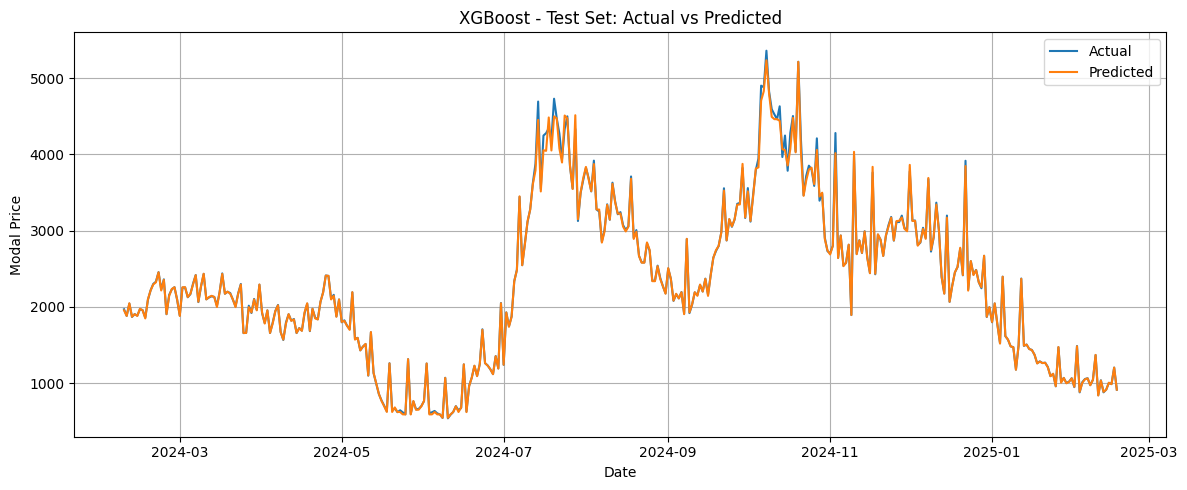

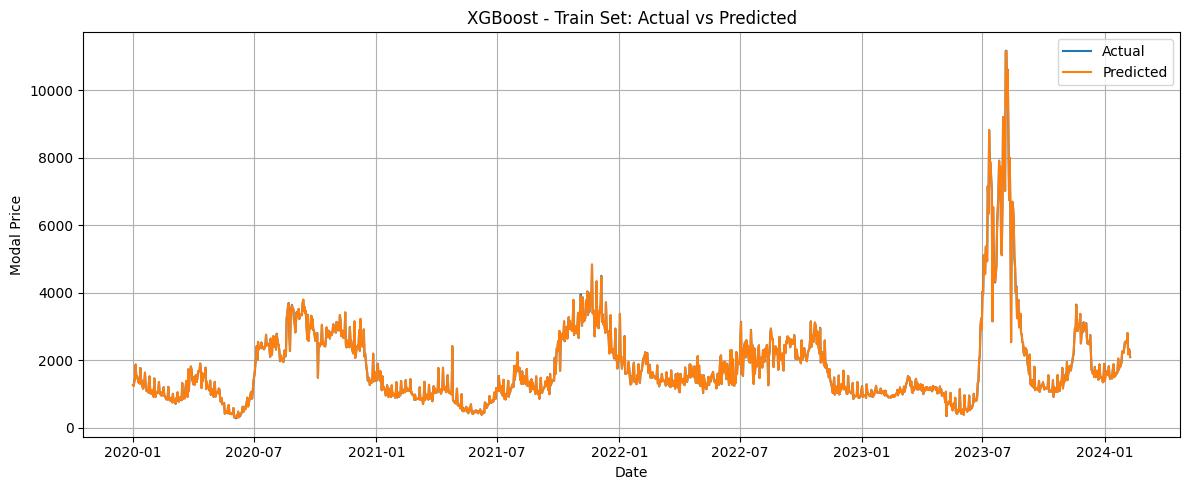

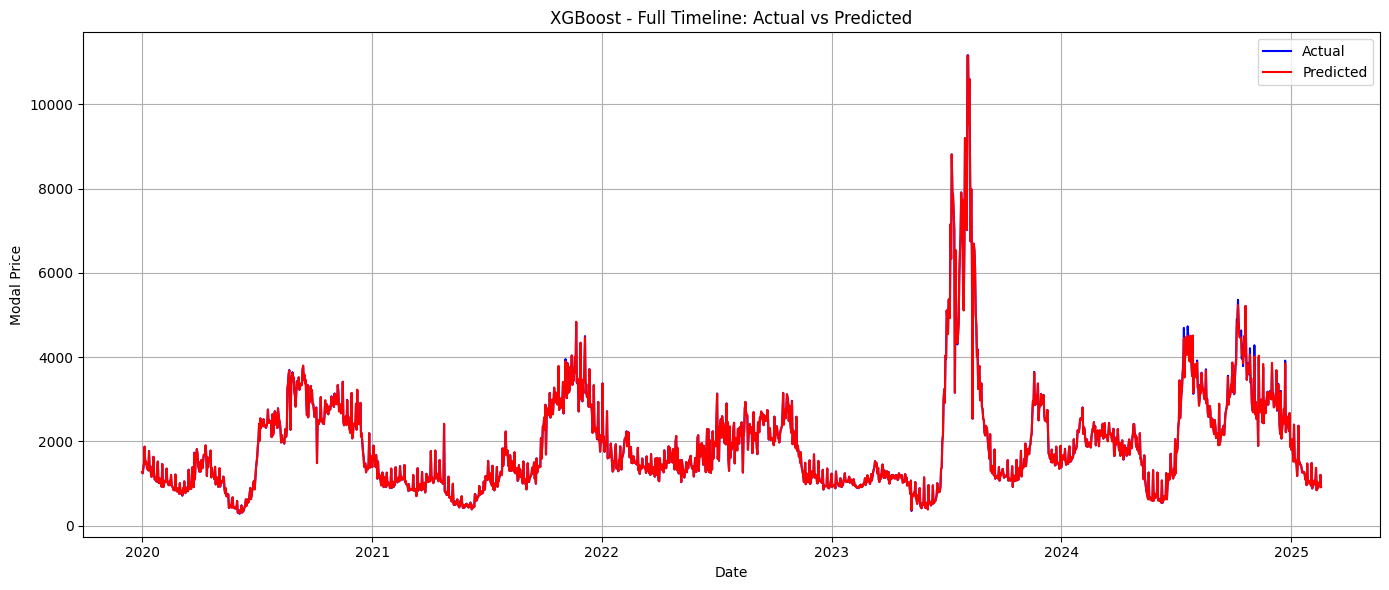

In [6]:
# Visualization - Test
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_test_pred, label='Predicted')
plt.title("XGBoost - Test Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Visualization - Train
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Actual')
plt.plot(y_train.index, y_train_pred, label='Predicted')
plt.title("XGBoost - Train Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Combine Actual and Predicted for Full Dataset Visualization
full_actual = pd.concat([y_train, y_test])
full_predicted = pd.concat([pd.Series(y_train_pred, index=y_train.index), pd.Series(y_test_pred, index=y_test.index)])

# Visualization - Full Timeline
plt.figure(figsize=(14, 6))
plt.plot(full_actual.index, full_actual, label='Actual', color='blue')
plt.plot(full_predicted.index, full_predicted, label='Predicted', color='red')
plt.title("XGBoost - Full Timeline: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Auto SARIMA

## Implementation

In [7]:
df = pd.read_csv('../datasets/processed/agmarknet_punjab_tomato.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
y = df['modal_price']

# Train-Test Split
split_index = int(len(y) * 0.8)
y_train, y_test = y[:split_index], y[split_index:]

# Auto SARIMA model
model = auto_arima(
    y_train,
    seasonal=True,
    m=7,  # adjust based on your seasonality (e.g., 12 for monthly, 7 for weekly, 30 for approx monthly in daily data)
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    error_action='ignore',
    max_order=10
)

print("\nBest SARIMA parameters:", model.order, model.seasonal_order)

# Forecast
n_periods = len(y_test)
y_pred = model.predict(n_periods=n_periods)
y_pred = pd.Series(y_pred, index=y_test.index)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=22421.444, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=22177.489, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=22138.621, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=22419.447, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=22143.688, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=22059.719, Time=1.15 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=21965.604, Time=2.64 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=21966.932, Time=3.15 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=21964.955, Time=2.21 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=22021.016, Time=0.97 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=22134.848, Time=0.19 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=22206.120, Time=2.22 sec
 ARIMA(1,1,1)(2,0,1)[7] interce

## Visualization

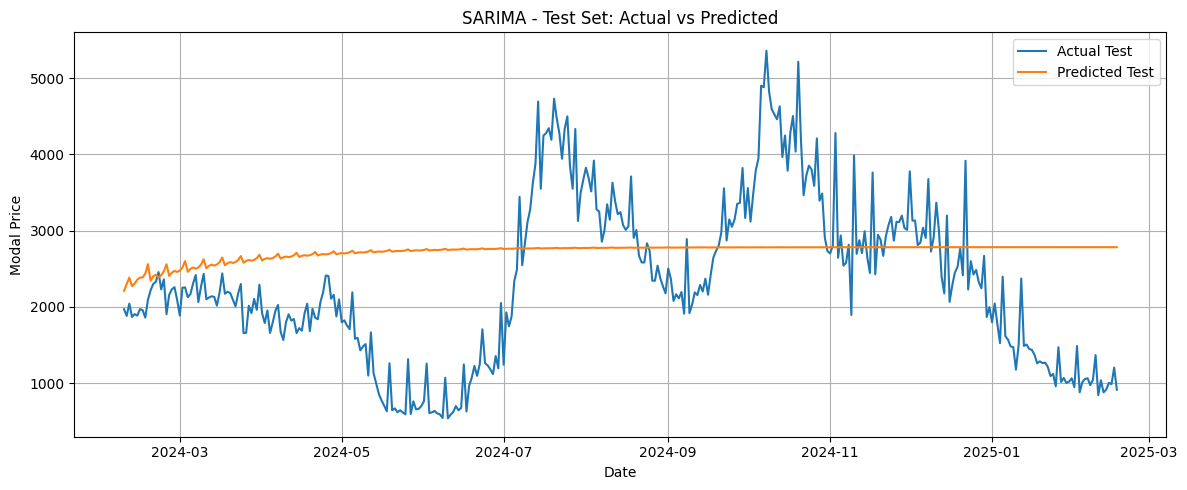

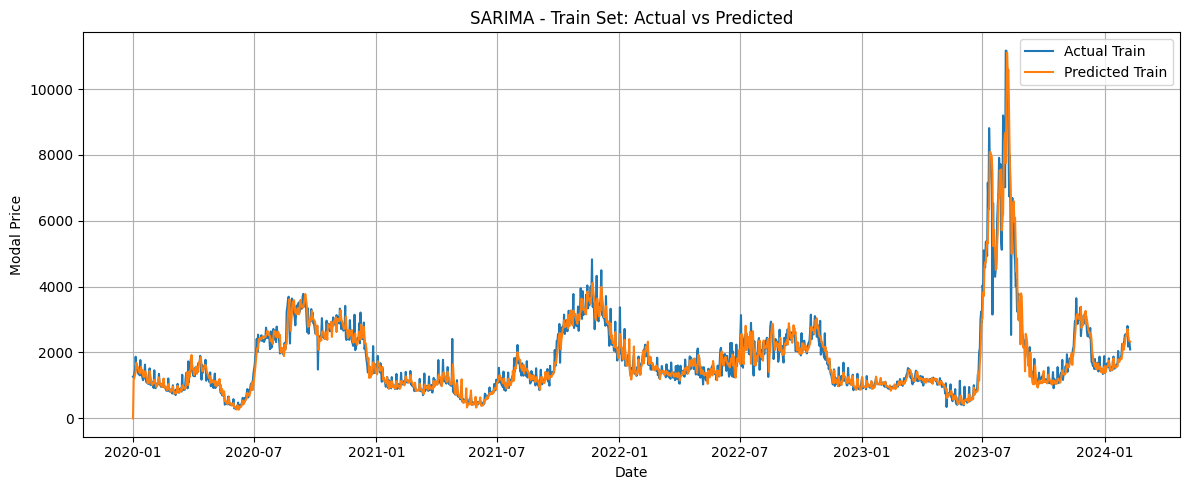

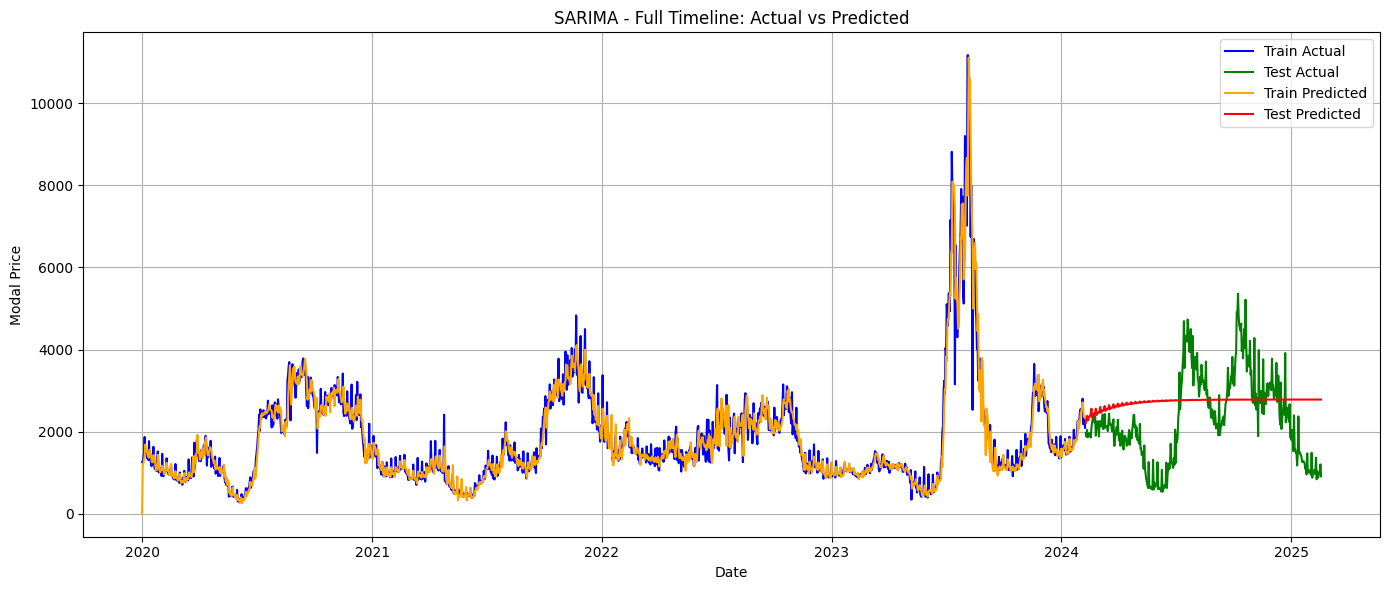

In [8]:
# Train predictions
y_train_pred = pd.Series(model.predict_in_sample(), index=y_train.index)

# Test predictions (already calculated)
y_test_pred = pd.Series(y_pred, index=y_test.index)

# Plot - Test Set
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual Test')
plt.plot(y_test.index, y_test_pred, label='Predicted Test')
plt.title("SARIMA - Test Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot - Train Set
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Actual Train')
plt.plot(y_train.index, y_train_pred, label='Predicted Train')
plt.title("SARIMA - Train Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot - Full Timeline
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Train Actual', color='blue')
plt.plot(y_test.index, y_test, label='Test Actual', color='green')
plt.plot(y_train.index, y_train_pred, label='Train Predicted', color='orange')
plt.plot(y_test.index, y_test_pred, label='Test Predicted', color='red')
plt.title("SARIMA - Full Timeline: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
print(mae, rmse, r2)

909.5069801150815 1116.4824623349757 -0.12392418558742202
